# K-Means
One of the methods described in the paper was using K-Means. When imputing using K-Means, you take the k closest samples (based on a certain distance measure) and take the mean of the values of the features in those samples. This gives you a complete vector, which you can use your classifier on. Instead of imputation, it's also possible to use K-means immediately for predicting. You search the k-closest samples and let them vote for the class your test sample should be.

## K-Means imputation
Let's impute the missing values using K-Means and predict using a random forest classifier.

Imputing must be done after get_features, because distance function often work better on numbers.

In [1]:
# We're lucky, sklearn already has a KNNImputer built in: https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from util import get_train_dataset, get_features, fix_test

df = get_train_dataset()
# df = df.sample(n=1000)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

x = get_features(df_train)
y = df_train['reaction']

x_test = get_features(df_test,test=True)
y_test = df_test['reaction']

x_test = fix_test(x_test, x.columns)

imputer = KNNImputer(n_neighbors=5)

x_imputed = imputer.fit_transform(x)
x_test_imputed = imputer.transform(x_test)

C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = np.nan  # TODO: NaN geven


In [2]:
clf = RandomForestClassifier(random_state=42)
clf.fit(x_imputed, y)

RandomForestClassifier(random_state=42)

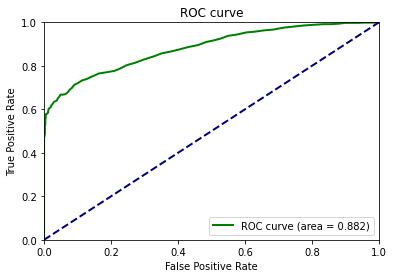

0.8821715138172759

In [3]:
from util import calculate_auc_and_plot
y_pred = clf.predict_proba(x_test_imputed)[:, 1]
calculate_auc_and_plot(y_test, y_pred)

In [ ]:
# Way to good accuracy, I noticed test=True wasn't set, so let's see what difference that makes
# Doing this again to reset the one hot encoder (and not use the test version)
x = get_features(df_train)
y = df_train['reaction']


x_test = get_features(df_test, test=True)
y_test = df_test['reaction']

x_test = fix_test(x_test, x.columns)

x_test_imputed = imputer.transform(x_test)

y_pred = clf.predict_proba(x_test_imputed)[:, 1]
calculate_auc_and_plot(y_test, y_pred)

# K-Means prediction

## Imputed data
Let's try it on the imputed data

In [ ]:
# For this, we can use the KNNClassifier from sklearn
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=5)

clf.fit(x_imputed, y)

In [ ]:
y_pred = clf.predict_proba(x_test_imputed)[:, 1]
calculate_auc_and_plot(y_test, y_pred)

# Immediate prediction

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

df = get_train_dataset()
# df = df.sample(n=1000)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

x = get_features(df_train)
y = df_train['reaction']

x_test = get_features(df_test, test=True)
y_test = df_test['reaction']

x_test = fix_test(x_test, x.columns)

In [ ]:
# For the classifier to work, we need to remove the Nan's, let's try filling them with 0
x_zero_imputed = x.fillna(0)
x_test_zero_imputed = x_test.fillna(0)

In [ ]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(x_zero_imputed, y)

In [ ]:
y_pred = clf.predict_proba(x_test_zero_imputed)[:, 1]
calculate_auc_and_plot(y_test, y_pred)

In [ ]:
# Let's try filling them with the mean
from sklearn.impute import SimpleImputer
import numpy as np
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
x_mean_imputed = imp_mean.fit_transform(x)
x_test_mean_imputed = imp_mean.transform(x_test)

In [ ]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(x_mean_imputed, y)

In [ ]:
y_pred = clf.predict_proba(x_test_mean_imputed)[:, 1]
calculate_auc_and_plot(y_test, y_pred)

# Summary
When first converting the dataset into feature and then imputing the missing values using a KNNImputer, we get (using random forest) an AUC of 0.837 (or 0.987 when generating features without Test=True). 0.837 is sligthly worse than the AUC I get when not using imputation and filling the NaN's with 0 (AUC=0.871).

The KNeigborsClassifier didn't support missing values, so I tried different ways to impute then, to classify them afterwards with the KNeigborsClassifier. Imputing using KNNImputer gave an AUC of 0.75, zeros 0.811 and the mean 0.791.

## After comment
When generating the master overview
I didn't try using different distance measure here. This is especially important since some distance based methods seem to work quite well for TCR classifications and the sklearn kneighborsclassifier supports custom distance measures.
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.distance_metrics.html#sklearn.metrics.pairwise.distance_metrics
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.nan_euclidean_distances.html
https://scikit-learn.org/stable/modules/metrics.html#metrics

Nvm, it doens't make sense to incorporate nan's here, since if the closest value is a nan, then it's still useless

## custom distance measures
sklearn KNN implmentation doesn't support strings, so let's use our own model

In [93]:
from functools import lru_cache
import numpy as np
from collections import Counter
from sklearn.metrics import pairwise_distances

class KNNString:
    def __init__(self, k, metric, metric_kwargs=None):
        self.k = k
        self.metric = metric
        self.metric_kwargs = metric_kwargs if metric_kwargs is not None else {}

    def fit(self, X, y):
        self.X_train = X.reset_index(drop=True)
        self.y_train = y.reset_index(drop=True)
        self.classes_ = np.unique(y)

    def predict(self, X):
        y_pred = []
        for i, row_to_predict in X.iterrows():
            distances = []
            for j, row_train in self.X_train.iterrows():
                dist = self.metric(row_train, row_to_predict, **self.metric_kwargs)
                distances.append(dist)
            indices = np.argsort(distances)[:self.k]
            k_nearest_labels = [self.y_train[i] for i in indices]
            most_common = Counter(k_nearest_labels).most_common(1)
            y_pred.append(most_common[0][0])
        return np.array(y_pred)

    def predict_proba(self, X):
        y_pred_proba = []
        for i, row_to_predict in X.iterrows():
            distances = []
            for j, row_train in self.X_train.iterrows():
                dist = self.metric(row_train, row_to_predict, **self.metric_kwargs)
                distances.append(dist)
            indices = np.argsort(distances)[:self.k]
            k_nearest_labels = [self.y_train[i] for i in indices]
            label_counts = Counter(k_nearest_labels)
            probabilities = [label_counts[label] / self.k for label in self.classes_]
            y_pred_proba.append(probabilities)
        return np.array(y_pred_proba)


In [94]:
def levenstein_distance(a, b):
    @lru_cache(None)  # for memorization
    def min_dist(s1, s2):

        if s1 == len(a) or s2 == len(b):
            return len(a) - s1 + len(b) - s2

        # no change required
        if a[s1] == b[s2]:
            return min_dist(s1 + 1, s2 + 1)

        return 1 + min(
            min_dist(s1, s2 + 1),      # insert character
            min_dist(s1 + 1, s2),      # delete character
            min_dist(s1 + 1, s2 + 1),  # replace character
        )

    return min_dist(0, 0)

In [95]:
def multi_lev(a, b):
    return np.mean([levenstein_distance(a_, b_) for a_, b_ in zip(a, b)])

In [96]:
from util import get_train_dataset, get_features, fix_test, calculate_auc_and_plot
from sklearn.model_selection import train_test_split

df = get_train_dataset()
df.dropna(inplace=True)
df = df.sample(n=500)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train.head()

,CDR3_alfa,TRAV,TRAJ,CDR3_beta,TRBV,TRBJ,reaction
4081,CAVNSYYNQGGKLIF,TRAV12-2,TRAJ23,CSVLQGSPYEQYF,TRBV29-1,TRBJ2-7,1
427,CVVSLNTGTASKLTF,TRAV12-1,TRAJ44,CASSSSAGSPLHF,TRBV6-5,TRBJ1-6,0
2656,CLVAAPRVGYALNF,TRAV4,TRAJ41,CASMWPSTEQFF,TRBV9,TRBJ2-1,0
1122,CLEGGTASKLTF,TRAV21,TRAJ44,CASGLIPGLGRETQYF,TRBV12-5,TRBJ2-5,0
2055,CAVPPGNDYKLSF,TRAV12-2,TRAJ20,CSVLGTPDYEQYF,TRBV29-1,TRBJ2-7,0


In [97]:
x = df_train[['CDR3_alfa', 'CDR3_beta']]
y = df_train['reaction']

x_test = df_test[['CDR3_alfa', 'CDR3_beta']]
y_test = df_test['reaction']

In [98]:
clf = KNNString(k=5, metric=multi_lev)
clf.fit(x, y)

In [99]:
y_pred = clf.predict(x_test)
print(np.mean(y_pred == y_test))

0.82


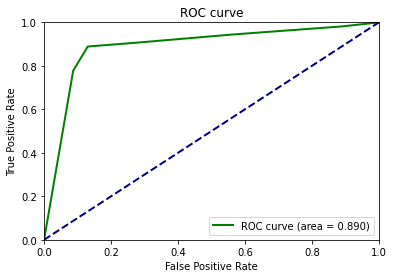

0.890096618357488

In [100]:
y_preda = clf.predict_proba(x_test)[:, 1]
calculate_auc_and_plot(y_test, y_preda)

### moved to util

In [19]:
from util import get_train_dataset, get_features, fix_test, calculate_auc_and_plot, KNNString, multi_lev
from sklearn.model_selection import train_test_split

df = get_train_dataset()
df = df.sample(n=500)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train.head()

,CDR3_alfa,TRAV,TRAJ,CDR3_beta,TRBV,TRBJ,reaction
5856,NaN,NaN,NaN,CASSYFRRLPGQVFYEQYF,TRBV6-2,TRBJ2-7,1
6541,CAENMGGGSQGNLIF,TRAV13-2,TRAJ42,CASSDRSGNTIYF,TRBV19,TRBJ1-3,1
7663,CAGAHGSSNTGKLIF,TRAV27,TRAJ37,CASSIRSAYEQYF,TRBV19,TRBJ2-7,1
5678,CAMRERGNEKLTF,TRAV14DV4,TRAJ48,CASSLYQETQYF,TRBV7-8,TRBJ2-5,0
4329,NaN,NaN,NaN,CASSGRQGGLLWETQYF,TRBV25-1,TRBJ2-5,0


In [20]:
x = df_train[['CDR3_alfa', 'CDR3_beta']]
y = df_train['reaction']

x_test = df_test[['CDR3_alfa', 'CDR3_beta']]
y_test = df_test['reaction']

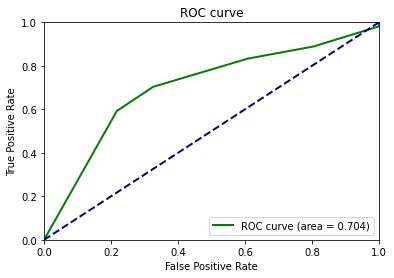

0.7035024154589371

In [21]:
clf = KNNString(k=5, metric=multi_lev, metric_kwargs={'nan_distance': 0})
clf.fit(x, y)
y_preda = clf.predict_proba(x_test)[:, 1]
calculate_auc_and_plot(y_test, y_preda)

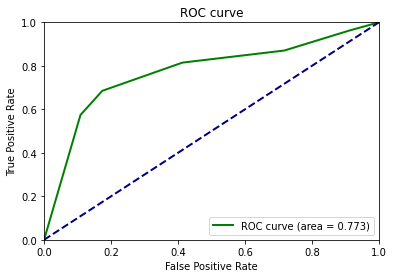

0.7727455716586152

In [22]:
clf = KNNString(k=5, metric=multi_lev, metric_kwargs={'nan_distance': 10000})
clf.fit(x, y)
y_preda = clf.predict_proba(x_test)[:, 1]
calculate_auc_and_plot(y_test, y_preda)

In [23]:
import pandas as pd

# drop nan's from x and y
xy = pd.concat([x, y], axis=1)
xy.dropna(inplace=True)
x = xy[['CDR3_alfa', 'CDR3_beta']]
y = xy['reaction']

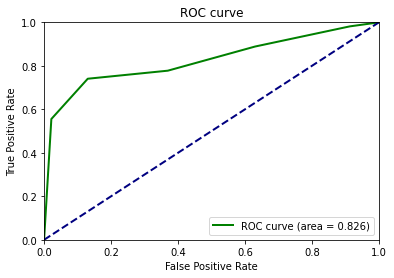

0.8258856682769725

In [24]:
clf = KNNString(k=5, metric=multi_lev)
clf.fit(x, y)
y_preda = clf.predict_proba(x_test)[:, 1]
calculate_auc_and_plot(y_test, y_preda)